In [72]:
#!git clone https://github.com/biraaj/Caltech101-Airplanes-Motorbikes-Schooners.git

In [73]:
#Importing Libraries

from torchvision import transforms, datasets, models
import torch
import torchvision
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torch.utils.data as data

In [74]:
#Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
images_path = "../input/caltech101-airplanes-motorbikes-schooners/caltech101_classification"

In [164]:
#Applying Image Tranformations
transformer = transforms.Compose(
    [
        transforms.Resize((244, 244)), # As vgg takes 244*244 input
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]  ## As reference to the imagenet mean and std standard practice.
        ),
    ]
)
dataset = ImageFolder(images_path, transform=transformer)

In [165]:
# Here the classes are recognized according to folder structure if we use ImageFolder from torchvison.
total_class = dataset.classes
print(total_class)

['Motorbikes', 'airplanes', 'schooner']


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


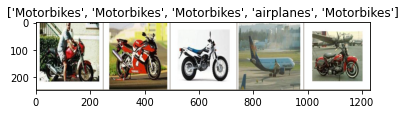

In [166]:
# Viewing Image After Transformation
def show_image(_input, _classes=None):
    input = _input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if _classes is not None:
        plt.title(_classes)
    plt.pause(0.002)

dataloader_to_view = data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=10)

# Getting samples of dataset
inputs, classes = next(iter(dataloader_to_view))

output_image_prepreprocessed = torchvision.utils.make_grid(inputs)

show_image(output_image_prepreprocessed, _classes=[total_class[y] for y in classes])

In [167]:
# Random split (train:6 valid:2 test:2)
train_set_size = int(len(dataset) * 0.6)
valid_set_size = int(len(dataset)*0.2)
test_set_size = valid_set_size + 1

In [168]:
print(train_set_size,valid_set_size,test_set_size)

996 332 333


In [169]:
train_set, valid_set, test_set = data.random_split(dataset, [train_set_size, valid_set_size, test_set_size])

In [170]:
# Training Sampler
## Collecting all the indices that the training set contains.
train_indices = train_set.indices

#Collecting the list with image target['Motorbikes':0, 'airplanes':1, 'schooner':2]
train_list = [dataset.targets[i] for i in train_indices]

# Sample count for each class([478 480 38])
train_class_sample_count = np.array(
    [len(np.where(train_list == t)[0]) for t in np.unique(train_list)])

In [171]:
# Finding weight of each class
train_weight = 1/ train_class_sample_count

# Assigning weight to each index
train_samples_weight = np.array([train_weight[t] for t in train_list])
train_samples_weight = torch.from_numpy(train_samples_weight)

In [172]:
# Validation Sampler
valid_indices = valid_set.indices

valid_list = [dataset.targets[i] for i in valid_indices]

valid_class_sample_count = np.array(
    [len(np.where(valid_list == t)[0]) for t in np.unique(valid_list)])

In [173]:
valid_weight = 1/ valid_class_sample_count
valid_samples_weight = np.array([valid_weight[t] for t in valid_list])
valid_samples_weight = torch.from_numpy(valid_samples_weight)

In [174]:
#Balancing imbalanced classes
train_sampler = WeightedRandomSampler(train_samples_weight.type('torch.DoubleTensor'), len(train_samples_weight))

In [175]:
valid_sampler = WeightedRandomSampler(valid_samples_weight.type('torch.DoubleTensor'), len(valid_samples_weight))

In [176]:
# Loading data into RAM
train_dataloader = data.DataLoader(train_set, batch_size=4, sampler=train_sampler)
valid_dataloader = data.DataLoader(valid_set, batch_size=4, sampler=valid_sampler)
test_dataloader = data.DataLoader(test_set, batch_size=4)

In [177]:
# VGG16
class VGG16(nn.Module):
    def __init__(self, classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, classes))
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = self.layer5(res)
        res = self.layer6(res)
        res = self.layer7(res)
        res = self.layer8(res)
        res = self.layer9(res)
        res = self.layer10(res)
        res = self.layer11(res)
        res = self.layer12(res)
        res = self.layer13(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [178]:
class VGG19(nn.Module):
    def __init__(self, classes=10):
        super(VGG19, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer14 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU())
        self.layer15 = nn.Sequential(
          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU())
        self.layer16 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, classes))
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = self.layer5(res)
        res = self.layer6(res)
        res = self.layer7(res)
        res = self.layer8(res)
        res = self.layer9(res)
        res = self.layer10(res)
        res = self.layer11(res)
        res = self.layer12(res)
        res = self.layer13(res)
        res = self.layer14(res)
        res = self.layer15(res)
        res = self.layer16(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.fc1(res)
        res = self.fc2(res)
        return res

In [179]:
class SimpleCNNFourLayer(nn.Module):
    def __init__(self, classes=10):
        super(SimpleCNNFourLayer, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pooling1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pooling2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc = nn.Linear(36864, 128)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128, classes)
        
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.relu(res)
        res = self.fc1(res)
        return res

In [152]:
class SimpleCNNFourLayerv2(nn.Module):
    def __init__(self, classes=10):
        super(SimpleCNNFourLayerv2, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.max_pooling1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.layer3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.layer4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        self.max_pooling2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc = nn.Linear(147456, 256)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(256, classes)
        
        
    def forward(self, x):
        res = self.layer1(x)
        res = self.layer2(res)
        res = self.layer3(res)
        res = self.layer4(res)
        res = res.reshape(res.size(0), -1)
        res = self.fc(res)
        res = self.relu(res)
        res = self.fc1(res)
        return res

In [153]:
def train(model, epochs, optimizer):
    total_step = len(train_dataloader)
    training_loss_values = []
    validation_loss_values = []

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (images, labels) in tqdm(enumerate(train_dataloader)):  
            # Loading tensor into configured device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss = running_loss + loss.item() 

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        training_loss_values.append(running_loss/train_set_size)

        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, epochs, i+1, total_step, loss.item()))

        # Validation
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in tqdm(valid_dataloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss = running_loss + loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs
            validation_loss_values.append(running_loss/train_set_size)

        print('model accuracy on {} validation images = {} %'.format(332, 100 * correct / total))
    return model, training_loss_values, validation_loss_values

In [94]:
def test_accuracy(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            tensors, predicted = torch.max(outputs.data, 1)
            total = total + labels.size(0)
            correct = correct + (predicted == labels).sum().item()
            del images, labels, outputs
        
        print('model accuracy on the {} test images: {} %'.format(333, 100 * correct / total)) 

In [180]:
# Hyper parameter Tuning

classes = 3
epochs = 5
batch_size = 50
learning_rate = 0.005
historical_result = []

#model3 = VGG16(classes).to(device)
model4 = VGG19(classes).to(device)
#model1 = SimpleCNNFourLayer(classes).to(device)
#model2 = SimpleCNNFourLayerv2(classes).to(device)
#model =torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=False)


# Loss function and optimizer
criterion  = nn.CrossEntropyLoss()
#optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.5)
# optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.5)
#optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.5)
optimizer4 = torch.optim.SGD(model4.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.5)  




In [96]:
#model.eval()

In [97]:
# dir(train_dataloader)
# len(train_dataloader.dataset)

In [102]:
def plot_loss_graph(train,valid,title):
    plt.plot(train, label="train")
    plt.plot(valid, label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title(title)
    plt.show()
    

In [155]:
# Training

model1, train_loss1, valid_loss1 = train(model1,epochs,optimizer1)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/5], Step [249/249], Loss: 0.0129


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 87.65060240963855 %


0it [00:00, ?it/s]

Epoch [2/5], Step [249/249], Loss: 0.0642


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 87.65060240963855 %


0it [00:00, ?it/s]

Epoch [3/5], Step [249/249], Loss: 0.0065


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.06024096385542 %


0it [00:00, ?it/s]

Epoch [4/5], Step [249/249], Loss: 0.0008


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.06024096385542 %


0it [00:00, ?it/s]

Epoch [5/5], Step [249/249], Loss: 0.0022


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.96385542168674 %


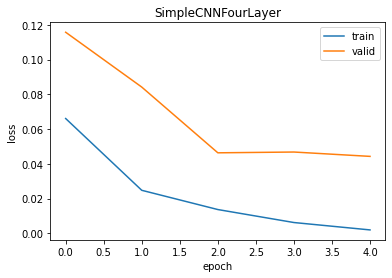

In [156]:
plot_loss_graph(train_loss1,valid_loss1,"SimpleCNNFourLayer")

In [162]:
test_accuracy(model1)

model accuracy on the 333 test images: 96.996996996997 %


In [105]:
model2, train_loss2, valid_loss2 = train(model2,epochs,optimizer2)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/5], Step [249/249], Loss: 0.0039


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 92.46987951807229 %


0it [00:00, ?it/s]

Epoch [2/5], Step [249/249], Loss: 0.7033


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 94.57831325301204 %


0it [00:00, ?it/s]

Epoch [3/5], Step [249/249], Loss: 0.0003


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 94.87951807228916 %


0it [00:00, ?it/s]

Epoch [4/5], Step [249/249], Loss: 0.0010


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 98.79518072289157 %


0it [00:00, ?it/s]

Epoch [5/5], Step [249/249], Loss: 0.0003


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.06024096385542 %


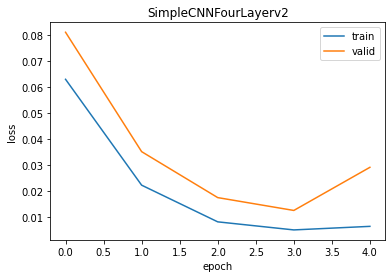

In [106]:
plot_loss_graph(train_loss2,valid_loss2,"SimpleCNNFourLayerv2")

In [107]:
test_accuracy(model2)

model accuracy on the 333 test images: 94.5945945945946 %


In [124]:
model3, train_loss3, valid_loss3 = train(model3,epochs,optimizer3)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/5], Step [249/249], Loss: 0.2432


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 93.97590361445783 %


0it [00:00, ?it/s]

Epoch [2/5], Step [249/249], Loss: 0.0080


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 95.78313253012048 %


0it [00:00, ?it/s]

Epoch [3/5], Step [249/249], Loss: 0.0006


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 90.96385542168674 %


0it [00:00, ?it/s]

Epoch [4/5], Step [249/249], Loss: 0.0002


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 98.49397590361446 %


0it [00:00, ?it/s]

Epoch [5/5], Step [249/249], Loss: 0.0473


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 96.08433734939759 %


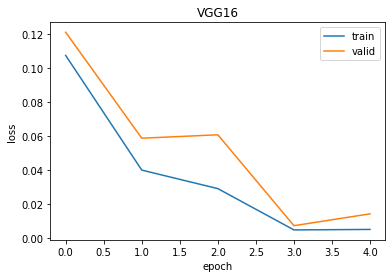

In [125]:
plot_loss_graph(train_loss3,valid_loss3,"VGG16")

In [126]:
test_accuracy(model3)

model accuracy on the 333 test images: 97.29729729729729 %


In [182]:
model4, train_loss4, valid_loss4 = train(model4,epochs,optimizer4)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/5], Step [249/249], Loss: 0.0144


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 89.4578313253012 %


0it [00:00, ?it/s]

Epoch [2/5], Step [249/249], Loss: 0.0295


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 93.67469879518072 %


0it [00:00, ?it/s]

Epoch [3/5], Step [249/249], Loss: 0.0005


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 98.19277108433735 %


0it [00:00, ?it/s]

Epoch [4/5], Step [249/249], Loss: 0.0012


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 96.3855421686747 %


0it [00:00, ?it/s]

Epoch [5/5], Step [249/249], Loss: 0.0006


  0%|          | 0/83 [00:00<?, ?it/s]

model accuracy on 332 validation images = 97.59036144578313 %


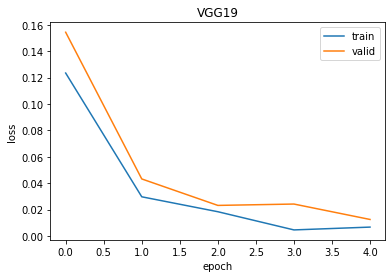

In [183]:
plot_loss_graph(train_loss4,valid_loss4,"VGG19")

In [184]:
test_accuracy(model4)

model accuracy on the 333 test images: 99.09909909909909 %


In [188]:
train_accuracies = [90.96,94.57,98.49, 98.19] #Best Epoch
test_accuracies = [96.99, 94.59, 97.29, 99.09] #Average test
models = ["CNNFourLayer", "CNNFourLayerv2", "vgg16", "vgg19"]

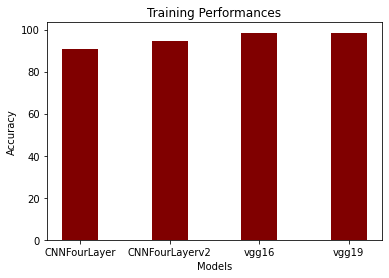

In [191]:
plt.bar(models, train_accuracies, color ='maroon',
        width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Training Performances")
plt.show()

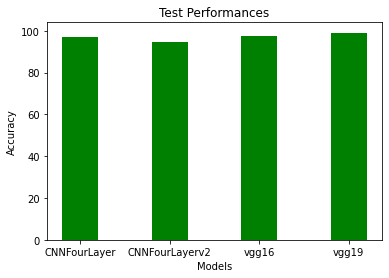

In [192]:
plt.bar(models, test_accuracies, color ='green',
        width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Test Performances")
plt.show()